<img src="PyDataLT0.png">

<img src="PyDataLT1.png">

<img src="PyDataLT2.png">

<img src="PyDataLT3.png">

---
---
> ***最適次数の選択***　⇒　統計モデルの生成　⇒　実測値と比較　⇒　未来を予測

In [1]:
import pandas as pd

# csv => data_frame
file_name = "source.csv"
df_source = pd.read_csv(file_name, index_col='date', parse_dates=True, dtype=float)

#=====================================================================================

import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore') # 警告非表示

# 試す次数の最大値
max_p = 3
max_d = 1
max_q = 3
max_sp = 1
max_sd = 1
max_sq = 1

# 次数の組み合わせを評価する指標：AIC を格納する空のデータフレームを準備
df_aic = pd.DataFrame(index=[], columns=["order_pattern", "AIC"])
    
# 総当たりで、AIC（赤池情報量基準）を計算する
num = 0
for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        # SARIMA (p, d, q)(sp, sd ,sq)[12]
                        sarima = sm.tsa.SARIMAX(
                            df_source, 
                            order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        # (p, d, q)(sp, sd ,sq) & AIC => df_aic
                        orders = "({},{},{})({},{},{})".format(p, d, q, sp, sd, sq)
                        result = pd.Series([orders, sarima.aic], index=df_aic.columns)
                        df_aic = df_aic.append(result, ignore_index=True)
                        num += 1
                        
df_aic.to_csv('order_aic.csv') # 計算結果をCSVデータに保存

In [2]:
# 最適な次数の組み合わせを求める
## AICは、小さいほど良い。　ただし、比較できるのは同じ統計モデルのみ
print(df_aic[df_aic.AIC == min(df_aic.AIC)])

      order_pattern          AIC
187  (3,1,3)(0,1,1)  1990.498236


---
> 最適次数の選択　⇒　***統計モデルの生成***　⇒　実測値と比較　⇒　未来を予測

In [3]:
# SARIMA(3,1,3)(0,1,1)[12] 統計モデル 
sarima = sm.tsa.SARIMAX(
    df_source, 
    order=(3, 1, 3), 
    seasonal_order=(0, 1, 1, 12), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()

---
> 最適次数の選択　⇒　統計モデルの生成　⇒　***実測値と比較***　⇒　未来を予測

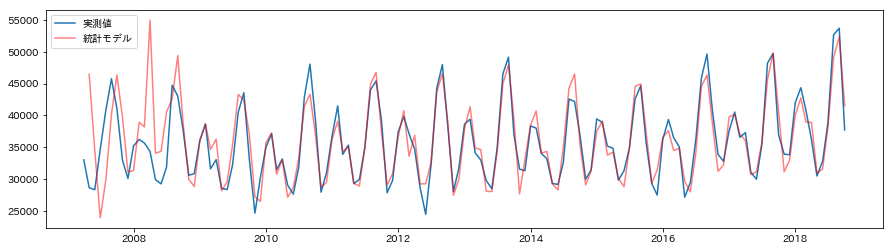

In [4]:
# 未来を予測する前に、実測値と統計モデルを比べてみる
from matplotlib import pylab as plt
%matplotlib inline

# SARIMA(3,1,3)(0,1,1)[12] 統計モデル で計算
df_model = sarima.predict('2007-05-01', '2018-10-01')

# 実測値と統計モデルのグラフ表示
plt.figure(figsize=(15,4)) # グラフを横長にする
plt.plot(df_source, label='実測値')
plt.plot(df_model, label='統計モデル', color='red', alpha=0.5)
plt.legend(loc='best') # 凡例表示
plt.savefig('df_model.png') # グラフを画像データに保存

---
> 最適次数の選択　⇒　統計モデルの生成　⇒　実測値と比較　⇒　***未来を予測***

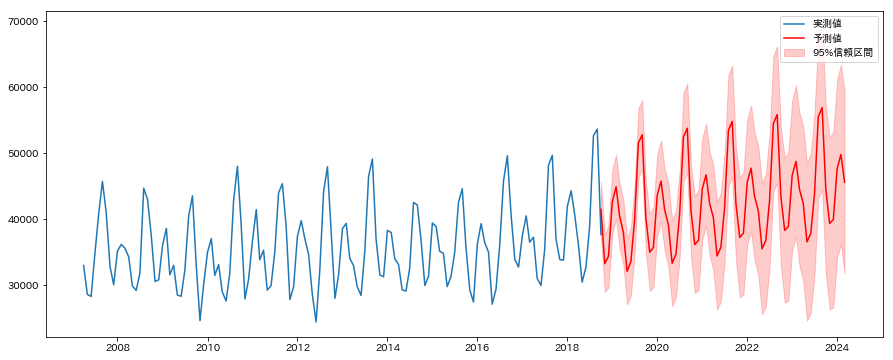

In [5]:
# いよいよ　未来を予測してみる
df_pred = sarima.predict('2018-10-01', '2024-03-01')
# ９５％信頼区間
df_pred_by = sarima.get_prediction('2018-10-01', '2024-03-01')
df_pred_ci = df_pred_by.conf_int(alpha=0.05)

# 予測結果のグラフ表示
plt.figure(figsize=(15,6)) # グラフを横長にする
plt.plot(df_source, label='実測値')
plt.plot(df_pred, label='予測値', color='red')
plt.fill_between(df_pred_ci.index, df_pred_ci.iloc[:, 0], df_pred_ci.iloc[:, 1], label='95%信頼区間', color='r', alpha=0.2)
plt.legend(loc='best') # 凡例表示

plt.savefig('pred.png') # グラフを画像データに保存
df_pred.to_csv('pred.csv') # 予測結果をCSVデータに保存
df_pred_ci.to_csv('pred_ci.csv') # 95%信頼区間をCSVデータに保存

---

<img src="PyDataLT9.png">

---
**補足資料**
---

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  139
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -987.249
Date:                            Wed, 19 Dec 2018   AIC                           1990.498
Time:                                    19:09:29   BIC                           2012.102
Sample:                                04-01-2007   HQIC                          1999.261
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2209      0.207      5.909      0.000       0.816       1.626
ar.L2         -1.1653      0.193   

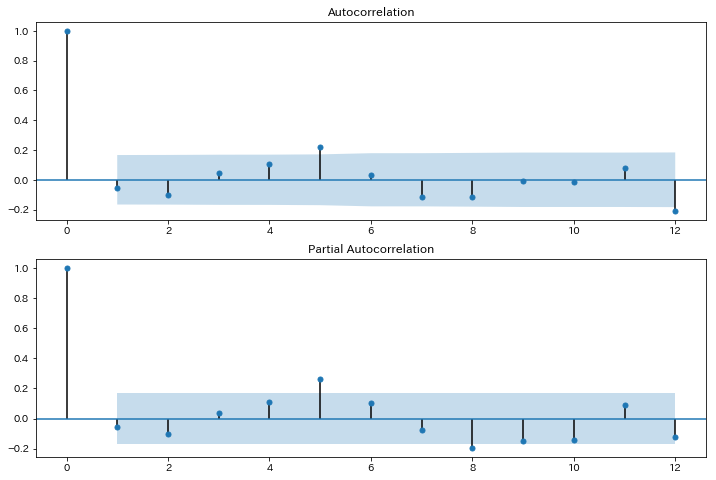

In [6]:
# 統計モデルのサマリー
print(sarima.summary())

# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))

# 自己相関
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=12, ax=ax1)

# 偏自己相関
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=12, ax=ax2)

---

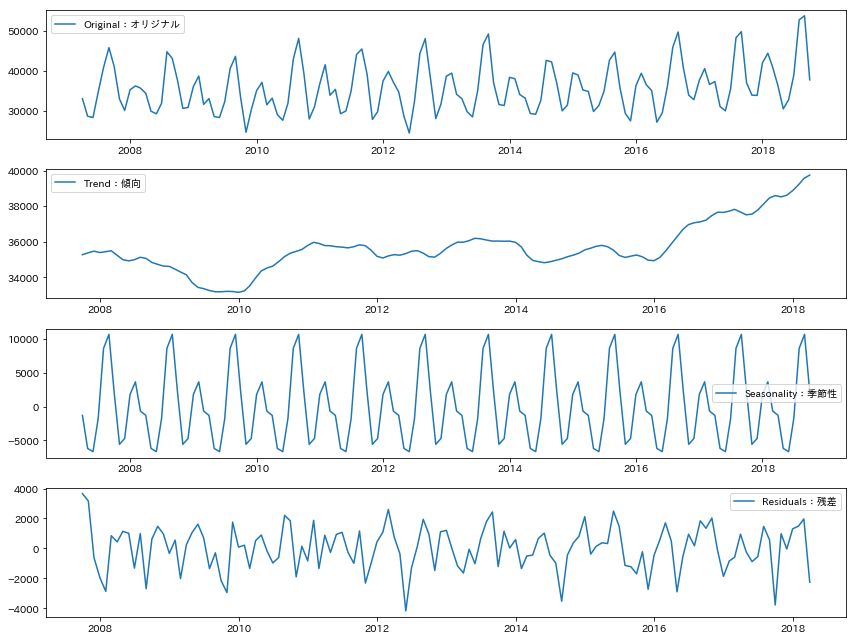

In [7]:
# 傾向(trend)、季節性(seasonal)、残差(residual)に分解してモデル化する。
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_source)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,9))
# オリジナルの時系列データプロット
plt.subplot(411)
plt.plot(df_source, label='Original：オリジナル')
plt.legend(loc='best')

# trend のプロット
plt.subplot(412)
plt.plot(trend, label='Trend：傾向')
plt.legend(loc='best')

# seasonal のプロット
plt.subplot(413)
plt.plot(seasonal,label='Seasonality：季節性')
plt.legend(loc='best')

# residual のプロット
plt.subplot(414)
plt.plot(residual, label='Residuals：残差')
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('tsr.png')

---